# 1.简单层的实现

我们把要实现的计算图的乘法节点称为"乘法层"(MulLayer)，加法节点称为"加法层"（AddLayer）。

In [1]:
#乘法层的实现
class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None
        
    def forward(self,x,y):
        self.x =x
        self.y =y
        out = x*y
        
        return out
    
    def backward(self,dout):
        dx = dout * self.y # 翻转x和y
        dy = dout * self.x
        
        return dx,dy
    
#__init__()中会初始化实例变量x和y,它们用于保存正向传播时的输入值。forward()接受x和y两个参数，将它们相乘后输出。
#backward()将从上游传来的导数（dout）乘以正向传播的翻转值，然后传给下游。

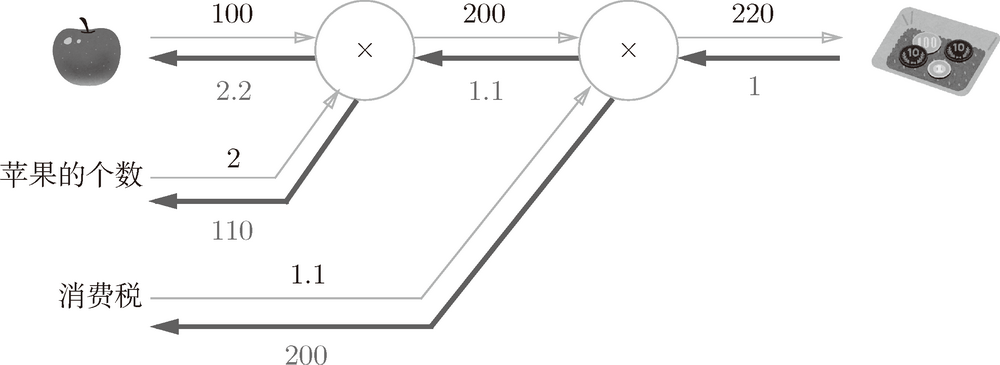
购买2个苹果的计算图

In [3]:
#用MulLayer实现上图中的购买2个苹果计算图的前向传播和反向传播

apple = 100
apple_num = 2
tax =1.1

#layer
mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

#forward
apple_price = mul_apple_layer.forward(apple,apple_num)
price = mul_tax_layer.forward(apple_price,tax)

print(price) #220

#backward
dprice =1
dapple_price,dtax = mul_tax_layer.backward(dprice)
dapple,dapple_num = mul_apple_layer.backward(dapple_price)

print(dapple,dapple_num,dtax) #2.2 110 200

220.00000000000003
2.2 110.00000000000001 200


In [4]:
#加法层的实现

class AddLayer:
    def __init__(self):
        pass
    
    def forward(self,x,y):
        out = x + y
        return out
    
    def backward(self,dout):
        dx = dout * 1
        dy = dout * 1
        return dx, dy
#加法层不需要特意进行初始化，所以_init__()中什么也不运行。加法层的forward()接收x和y两个参数，将它们相加后输出。
#backward()将上游传来的导数（dout）原封不动地传递给下游。   

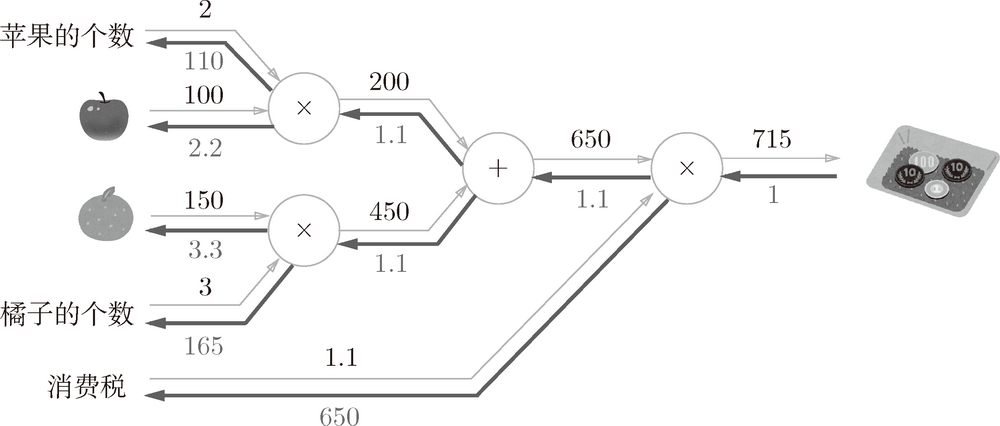
购买2个苹果和3个橘子的计算图

In [5]:
#用MulLayer和AddLayer实现购买两个苹果和3个橘子计算图的前向传播和反向传播

apple = 100
apple_num =2
orange =150
orange_num =3
tax = 1.1

#layer
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

#forward
apple_price = mul_apple_layer.forward(apple,apple_num) #(1)
orange_price = mul_orange_layer.forward(orange,orange_num) #(2)
all_price = add_apple_orange_layer.forward(apple_price,orange_price) #(3)
price = mul_tax_layer.forward(all_price,tax) #(4)

#backward
dprice = 1
dall_price,dtax = mul_tax_layer.backward(dprice) #(4)
dapple_price,dorange_price = add_apple_orange_layer.backward(dall_price) #(3)
dorange,dorange_num = mul_orange_layer.backward(dorange_price) #(2)
dapple,dapple_num = mul_apple_layer.backward(dapple_price) #(1)

print(price) #715
print(dapple_num,dapple,dorange,dorange_num,dtax) #110 2.2 3.3 165 650


715.0000000000001
110.00000000000001 2.2 3.3000000000000003 165.0 650


# 2.激活函数的实现
### ReLU层
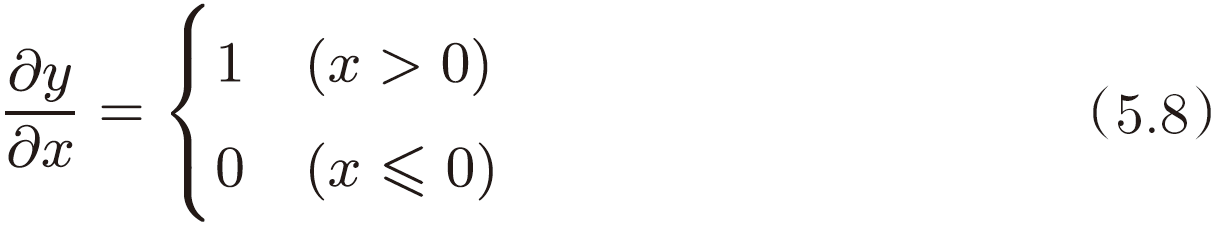
如果正向传播时的输入 x 大于 0，则反向传播会将上游的值原封不动地传给下游。反过来，如果正向传播时的 x 小于等于 0，则反向传播中传给下游的信号将停在此处。

In [6]:
#ReLU层的计算图
class Relu:
    def __init__(self):
        self.mask =None
        
    def forward(self,x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        
        return out
    
    def backward(self,dout):
        dout[self.mask] = 0
        dx = dout
        
        return dx
    
#Relu类有实例变量mask。这个变量mask是由True/False构成的NumPy数组，他会把正向传播时的输入x的元素中小于等于0的地方保存为True,其他地方（大于0的元素）保存为False。

### Sigmoid层
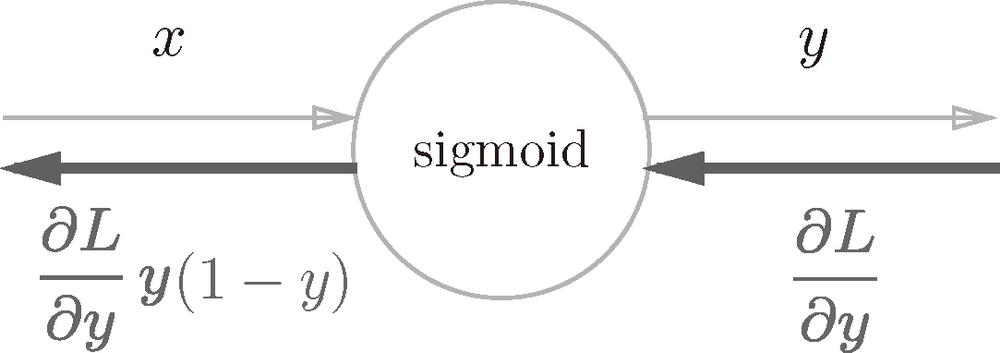
Sigmoid 层的计算图：可以根据正向传播的输出 y 计算反向传播

In [7]:
#Sigmoid层的python实现

class Sigmoid:
    def __init__(self,x):
        self.out = None
        
    def forward(self,x):
        out = 1/(1+np.exp(-x))
        self.out = out
        
        return out
    
    def backword(self,dout):
        dx = dout*(1.0 - self.out) * self.out
        
        return dx

#这个实现中，正向传播时将输出保存在了实例变量out中。然后，反向传播时，使用该变量out进行计算。

# 3.Affine/Softmax层的实现

### Affine层
神经网络的正向传播中进行的矩阵的乘积运算在几何学领域被称为"仿射变换"。几何中，仿射变换包括一次线性变换和一次平移，分别对应神经网络的加权和运算与加偏置运算。因此，这里将进行仿射变换的处理实现为"Affine层"。
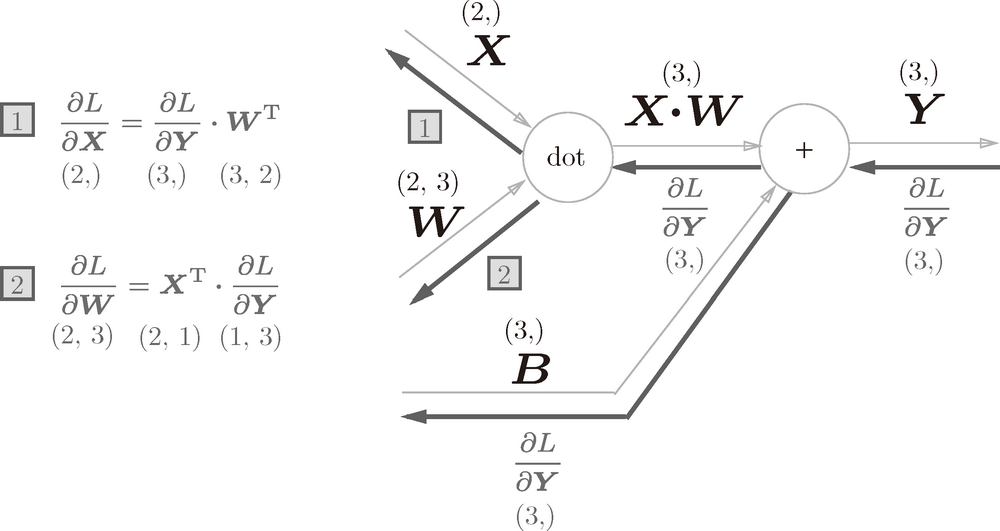
Affine层的计算图 变量是矩阵，各个变量上方标记了该变量的形状。反向传播时要注意变量的形状。

### 批版本的Affine层
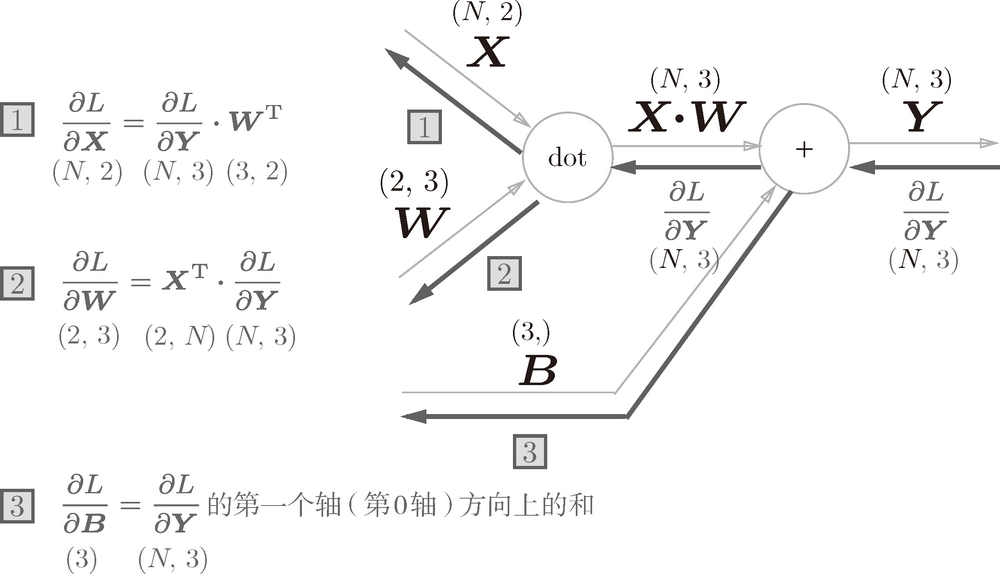
批版本的Affine层的计算图

In [8]:
#考虑输入数据为张量的Affine pythonS实现
class Affine:
    def __init__(self,W,b):
        self.W = W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 权重和偏置参数的导数
        self.dW = None
        self.db = None
        
    def forward (self,x):
        #对应张量
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0],-1)
        self.x = x
        out = np.dot(x,self.W)+self.b
        
        return out
    
    def backward(self,dout):
        dx = np.dot(dout,self.W.T)
        self.dW = np.dot(self.x.T,dout)
        self.db = np.sum(dout,axis=0)
        
        dx =dx.reshape(*self.original_x_shape) #还原输入数据的形状（对应张量）
        
        return dx

# Softmax-with-Loss层
在Softmax-with-Loss层的计算图中，softmax函数记为Softmax层，交叉熵误差记为Cross Entropy Error层。
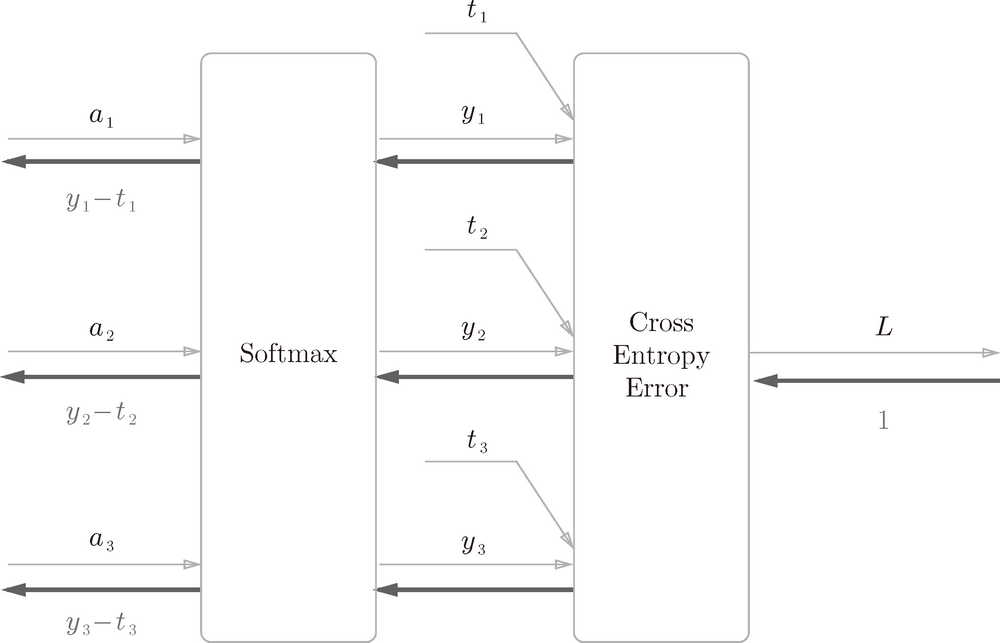
“简易版”的 Softmax-with-Loss 层的计算图

神经网络的反向传播会把Softmax层的输出和监督标签的差分表示的误差传递给前面的层，这是神经网络学习中的重要性质。

In [11]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None #损失
        self.y = None #softmax的输出
        self.t = None #监督数据（one-hot vector）
        
    def forward(self,x,t):
        self.t = t
        self.y  = softmax(x)
        self.loss = cross_entropy_error(self.y,self.t)
        
        return self.loss
    
    def backward(self,dout=1):
        batch_size =self.t.shape[0]
        dx = (self.y -self.t)/batch_size
        
        return dx
    

def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 溢出对策
    return np.exp(x) / np.sum(np.exp(x))

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 监督数据是one-hot-vector的情况下，转换为正确解标签的索引
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

# 5.7 误差反向传播法的实现
误差反向传播法可以快速高效地计算梯度

In [13]:
#使用误差反向传播法的python实现
import sys, os
sys.path.append(os.pardir)
import numpy as np
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict

class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size,
                 weight_init_std=0.01):
        # 初始化权重
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

        # 生成层
        self.layers = OrderedDict()
        self.layers['Affine1'] = \
            Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = \
            Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    # x:输入数据, t:监督数据
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    # x:输入数据, t:监督数据
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

        return grads

    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 设定
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db

        return grads

In [19]:
# coding: utf-8
#反向传播的梯度确认
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

# 读入数据
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

for key in grad_numerical.keys():
    diff = np.average( np.abs(grad_backprop[key] - grad_numerical[key]) )
    print(key + ":" + str(diff))

W1:4.5119621105645954e-10
b1:2.75015110431996e-09
W2:5.974973264157114e-09
b2:1.4045134996976128e-07


In [20]:
#使用误差反向传播法的学习
# coding: utf-8
import sys, os
sys.path.append(os.pardir)

import numpy as np
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

# 读入数据
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 梯度
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # 更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(train_acc, test_acc)

0.1035 0.1029
0.9036666666666666 0.9089
0.9207666666666666 0.9234
0.9355666666666667 0.9363
0.9442833333333334 0.943
0.9484 0.9473
0.9549 0.9528
0.9611166666666666 0.9568
0.9640833333333333 0.9589
0.9659166666666666 0.9616
0.9687 0.9626
0.9707833333333333 0.9652
0.9735666666666667 0.9677
0.9753833333333334 0.9676
0.9750666666666666 0.9665
0.9777 0.9694
0.9779666666666667 0.9697
